# Notebook to investigate the concentrations of HexCer and Cer when using only multi-point external standards for quantification

Literature suggests that HexCer and Cer represent a reasonable portion of the lipid content, and that HexCer accounts for more of the lipid content than Cer. Our results using the Lipidomics workflow suggested differently. To investigate this further, the concentrations of the different lipid classes were 'manually' probed, using external multi-point standards for the quantification of the different lipids. 

#### Notes about using one-point external standard quantification
 - "Analyte_HexCer t36:1" invalid due to QC Area
 - Picked standards to use according to primarily tail length, further details are under each heading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from DataProcessingFuncs import *

In [2]:
def fitAssesPoly(x_data, y_data, polynomialOrder=1):

    # curve fit the test data
    fittedParameters = np.polyfit(x_data, y_data, polynomialOrder)
    print('Fitted Parameters:', fittedParameters)

    modelPredictions = np.polyval(fittedParameters, x_data)
    absError = modelPredictions - y_data

    SE = np.square(absError) # squared errors
    MSE = np.mean(SE) # mean squared errors
    RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
    Rsquared = 1.0 - (np.var(absError) / np.var(y_data))
    print('RMSE:', RMSE)
    print('R-squared:', Rsquared)

    print()
    
    return fittedParameters
    
def ModelAndScatterPlot(graphWidth, graphHeight, x_data, y_data):
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(x_data, y_data,  'D')

    # create data for the fitted equation plot
    xModel = np.linspace(min(x_data), max(x_data))
    yModel = np.polyval(fittedParameters, xModel)

    # now the model as a line plot
    axes.plot(xModel, yModel)
    axes.set_xlabel('Area') # X axis data label
    axes.set_ylabel('Conc') # Y axis data label

    plt.show()
    plt.close('all') # clean up after using pyplot

## 1. Data Import and cleaning

In [3]:
# Import cell mass csv, generate a new column with columns 0 and 1 concatenated (e.g. C034_SS)
cellmass = pd.read_csv("../data/biomass/LipidCellMass.csv")
cellmass.loc[:,"Name"] = cellmass.iloc[:,0] + "_" + cellmass.iloc[:,1]
for i, name in enumerate(cellmass.Name.str.split("_")):
    if name[0] in ['C034',"C035", "C036"]:
        cellmass.loc[i, "Name"] = name[0] + "_C0.1" 
        
cellmass.set_index("Name", inplace=True)

CerHexdf = pd.read_csv("../data/biomass/static/CerHexCer.csv", header=None, index_col=0)
CerHexdict = CerHexdf.iloc[:,0].to_dict()

In [4]:
# Import measured total lipids result
TotLip = pd.read_csv("../data/biomass/LipidAnalysisResults.csv", index_col=[0])



# change formatting of CO23 to C023. Remove extra unneccesary rows from type and subset samples (not blank, ESTD, or QC)
TotLip.FileName = TotLip.FileName.str.replace('CO',"C0")
TotLip = TotLip[TotLip.Type.isin(["area","conc"])]
TotLip.iloc[:,2:]=TotLip.iloc[:,2:].astype(float)
samples = TotLip[~TotLip.FileName.str.contains("ESTD|Blank|QC")]
two_cols = samples.FileName.str.split("_pos_",expand=True)

# Some rows don't have a sampling point in the file name. Add one for compatability with cellmass
for i, row in two_cols.iterrows():
    if "_" not in row[0]:
        TotLip.loc[i,"FileName"] = row[0] + "_C0.1_" + row[1]
    else:
        TotLip.loc[i,"FileName"] = row[0] + "_" + row[1]
TotLip.set_index(["Type", "FileName"], inplace=True)

# Subset samples
mask = TotLip.index.get_level_values('FileName').str.contains("ESTD|Blank|QC")
samples = TotLip[~mask].copy()

# Subset HexCer and Cer ESTDs
estdcer = TotLip.columns.str.contains(r'(?=.*_Cer)(?=.*ESTD)',regex=True)
estdhexcer = TotLip.columns.str.contains(r'(?=.*[a-zA-Z]Cer)(?=.*ESTD)',regex=True)
estd_cols = TotLip.columns[estdcer+estdhexcer]
estd= TotLip.loc[:,estd_cols]
estd.reset_index(inplace=True)

# Extract the area rows for linear regression. Extract ESTD samples
estd = estd[estd.Type == "area"]
estd = estd[estd.FileName.str.contains("ESTD")]
estd_samples = estd.FileName.to_numpy()

estd["Conc"] = estd.FileName.str.extract('pos_(\d+)').astype(int)
estd.set_index("FileName",inplace=True)
conc_vec = estd["Conc"].to_numpy()




## Calculating concentrations

### 1. HexosylCeramides
- "Analyte_HexCer t36:1" invalid due to QC Area. Used HexCer d34:1 for quantifying HexCer t34:1 and t36:2.

- HexCer t36:1 dropped following manual inspection and recognition of a strong signal in the light fraction of the ESTD. Shouldn't be present.
- HexCer t44:2 dropped due to very low signal

### 2. Ceramides
- Using Cer d36:1 as the ESTD - used for concentration calculation for Cer d36:2. The following were dropped due to the very low areas reported Cer.. t36:0, t36:1, t36:2
- Using Cer d42:0 as the ESTD - used for concentration calculation for Cer.. e42:0 and e44:0
- Using Cer t42:1 as the ESTD - used for concentration calculation for Cer.. t42:0 and t44:0

ESTD_HexCer d34:1
Fitted Parameters: [6.18050120e-05 1.46294996e+01]
RMSE: 5.210008696705947
R-squared: 0.9994257476531587



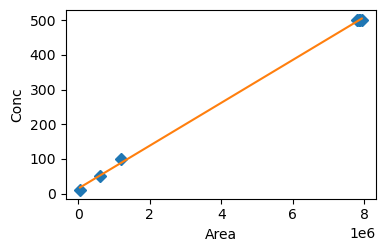

ESTD_Cer d36:1
Fitted Parameters: [5.44939543e-05 5.33731011e+00]
RMSE: 3.9968228046908507
R-squared: 0.9996620474937015



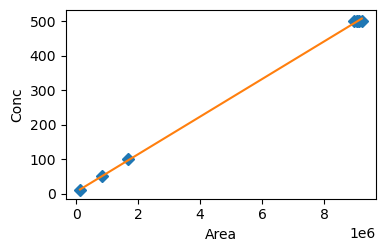

ESTD_Cer d42:0
Fitted Parameters: [3.75441930e-05 9.34547825e+00]
RMSE: 11.621361031748124
R-squared: 0.9971428050830573



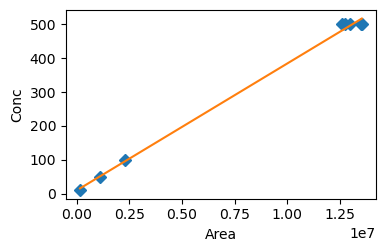

ESTD_Cer t42:1
Fitted Parameters: [9.29488605e-05 8.36814106e+00]
RMSE: 11.95391591552477
R-squared: 0.9969769434200093



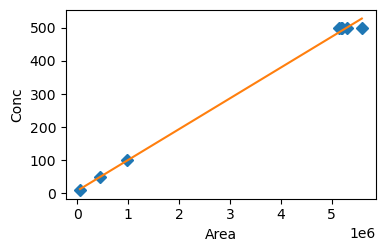

In [5]:
samples = TotLip[~mask].copy()
# Create Dataframe to hold all calcaualted concs/compositions
CalcCer = pd.DataFrame(index=samples.reset_index().FileName.unique())

graphWidth = 400
graphHeight = 250

ESTDs_to_use = {"Analyte_HexCer t34:2":"ESTD_HexCer d34:1",
                "Analyte_HexCer t36:2":"ESTD_HexCer d34:1", 
                "Analyte_Cer d36:2":"ESTD_Cer d36:1",
                "Analyte_Cer e42:0":"ESTD_Cer d42:0",
                "Analyte_Cer e44:0":"ESTD_Cer d42:0",
                "Analyte_Cer t42:0":"ESTD_Cer t42:1", 
                "Analyte_Cer t44:0":"ESTD_Cer t42:1"}

fitted_parameters = {}
for standard in ["ESTD_HexCer d34:1","ESTD_Cer d36:1","ESTD_Cer d42:0","ESTD_Cer t42:1"]:
    area_vec = estd.loc[estd_samples,standard].to_numpy()
    nan_mask = np.isnan(area_vec)
    # Know the values are small, so use the smaller concentrations and test linearity
    x_data=area_vec[[i for i,x in enumerate(conc_vec) if x in[10,50,100,500]]]
    y_data=conc_vec[[i for i,x in enumerate(conc_vec) if x in[10,50,100,500]]]
    area_vec = area_vec
    print(standard)
    
    fittedParameters = fitAssesPoly(x_data, y_data) # defaults to PolyOrder 1 = example straight line

    ModelAndScatterPlot(graphWidth, graphHeight, x_data, y_data)
    
    fitted_parameters[standard] = fittedParameters

# ESTDs_to_use = {k:fitted_parameters for k,v in ESTDs_to_use.items()}

sample_id = [x[0] for x in samples.index.get_level_values("FileName").str.rsplit("_",1)]
samples.loc[:,"YDM"] = cellmass.loc[sample_id,"YDM [gL-1]"].to_numpy()

samples.reset_index(inplace=True)
samples = samples[samples.Type == "area"]
samples.drop(columns="Type", inplace=True)

# # # "Analyte_HexCer t36:1" invalid due to QC Area, t44:2 due to very low are values
samples = samples[~samples.FileName.str.contains("ESTD|Blank|QC")]
ydm = samples.loc[:,"YDM"].to_numpy()
samples.set_index("FileName",inplace=True)
samples = samples.loc[:,["Analyte_HexCer t34:2","Analyte_HexCer t36:2", 
                         "Analyte_Cer d36:2",
                         "Analyte_Cer e42:0", "Analyte_Cer e44:0",
                         "Analyte_Cer t42:0", "Analyte_Cer t44:0"]]

for name, col in samples.iteritems():
    
    conc = np.polyval(fitted_parameters[ESTDs_to_use[name]], col.to_numpy())
    
    CalcCer.loc[:,f"Area_{name}"] = col
    CalcCer.loc[:,f"Conc_{name}"] = pd.Series(data=conc, index=col.index)
    
    formula = CerHexdict.get(name.split("_")[1])
    mass = metabolite(formula=formula).mass

    CalcCer.loc[:,f"Comp_mg/mg_{name}"] = pd.Series(data=(conc*2e-4*(2.2/0.2)*(mass/1e6))/ydm, index=col.index)


In [6]:
# Subset to give just the composition columns, then strip the Analyte tag 
comp_cer = CalcCer.loc[:,CalcCer.columns.str.contains("Comp")]
comp_cer.columns = comp_cer.columns.str.replace(".*Analyte_","", regex=True)

# Split the repeats for each sample point, then take the mean of the two repeats (pos)
comp_cer = comp_cer.set_index(comp_cer.index.str.rsplit("_",1, expand=True)).reset_index()
comp_cer = comp_cer.groupby("level_0").mean().T.reset_index()

# Generate a column with the lipid class for each species
comp_cer.loc[:,"Class"] = comp_cer.loc[:,"index"].str.split(" ",expand=True).loc[:,0]
comp_cer = comp_cer.rename(columns={"index":"Lipid"})
comp_cer.set_index("Lipid", inplace=True)

sep_cer = comp_cer.drop(columns="Class").T


# Split the sample ID into cultivation and smapling poitn info
sep_cer.index = sep_cer.index.str.split("_", expand=True)
sep_cer = sep_cer.reset_index().rename(columns={"level_0":"cultivation",
                                                  "level_1":"sample point"})
# groupby sample point, then aggregate using mean and sd on the HexCer and Cer columns
# sep_cer.groupby(["cultivation", "sample point"]).agg(['mean','std'])


In [7]:
total_cer = pd.DataFrame(comp_cer.groupby(["Class"]).sum().unstack())
total_cer = total_cer.reset_index().rename(columns={"level_0":"Sample",
                                       "Class":"Family", 0:"Value"})

total_cer["Sample Point"] = total_cer.Sample.str.split("_",1, expand=True)[1]
total_cer["Cultivation Group"] = "SC"
total_cer.loc[total_cer.Sample.str.contains("C034|C035|C036"), "Cultivation Group"] = "C0.1"
total_cer.to_csv("../data/biomass/measured/ManualCer.csv")